<a href="https://colab.research.google.com/github/jonmartz/RegressionTreeProject/blob/master/ex2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check if GPU is enabled:

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

Clone github project and install packages:

In [2]:
!git clone https://github.com/jonmartz/MachineLearningAss2
!pip install category_encoders
#!pip install shap

fatal: destination path 'MachineLearningAss2' already exists and is not an empty directory.


*Mount* google drive:


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports


In [4]:
# Import scikit-learn dataset library
import pandas as pd
import numpy as np
import csv
import pickle
import matplotlib.pyplot as plt
import shap  # package used to calculate Shap values
from sklearn import datasets
# Import train_test_split function
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from itertools import zip_longest
from joblib import dump, load
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# from sklearn.preprocessing import Imputer

import xgboost as xgb

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


initialization

In [5]:
target_col = 'CLASS'

parsed_train_set_encoded = []
parsed_test_set_encoded = []
dataset = []
train_set = []
train_set_encoded_a = []
test_set = []
test_set_encoded_b = []
to_drop = []

Offline testing - in local environment, spolitting train set to smaller train and test

In [6]:
# # =============================================================================
# ##### OFFLINE testing code ####### train & validation
# dataset = pd.read_csv("MachineLearningAss2/data/train.csv")
# train_fraction = 0.7
# ## remove columns with minimal data
# dataset =  rmissingvaluecol_onedf(dataset,80) #Here threshold is 10% which means we are going to drop columns having more than 10% of missing values
# ## deal with NaN pre-encoding
# #print("dataset pre impulation is:", dataset )
# strategy = 'most_frequent'
# dataset = missing_values_impul(dataset, strategy)
# #print("dataset post impulation is:", dataset)
# ## Drop correlated features
# dataset = drop_corr_feat(dataset)

# ## encoding
# train_set, train_set_encoded_a, test_set, test_set_encoded_b = train_test_split(dataset, train_fraction)
# #parsed_train_set_encoded = rmissingvaluecol_onedf(train_set_encoded_a,0.01) #Here threshold is 0.01% which means we are going to drop columns having more than 0.01% of missing values
# #parsed_test_set_encoded = rmissingvaluecol_onedf(test_set_encoded_b,0.01) #Here threshold is 0.01% which means we are going to drop columns having more than 0.01% of missing values

# ### removing columns to match train testing to actual testing
# #parsed_train_set_encoded, parsed_test_set_encoded_pre = rmissingvaluecol_twodf(parsed_train_set_encoded, parsed_train_set_encoded_pre, 0.01)
# #parsed_test_set_encoded, parsed_test_set_encoded_pre = rmissingvaluecol_twodf(parsed_test_set_encoded, parsed_test_set_encoded_pre, 0.01)


# ## AR: write code to drop dependant columns, save them and set as parameter to online test


# #print("\n for offline training train_set_encoded_a:\n", train_set_encoded_a)
# #print("\n for offline training test_set_encoded_b:\n", test_set_encoded_b)
# test(train_set_encoded_a, test_set_encoded_b, target_col, clf, "train")

# # =============================================================================


##### ONLINE testing code ####### 
train_set and test_set are used to generate pred file for kaggle competition


Reading train set file

In [7]:
dataset = pd.read_csv("MachineLearningAss2/data/train.csv")

Columns (1,2,4,5,7,8,9,10,11,13,14,15,17,18,19,20,23,24,26,27,28,33,34,35,36,37,38,39,40,44,45,46,47,48,49,64,70,71,78,80) have mixed types.Specify dtype option on import or set low_memory=False.


Removing columns with minimal info from train set

In [8]:
def rmissingvaluecol_onedf(dff, threshold):
    my_df = dff.copy()
    l = []
    l = list(my_df.drop(my_df.loc[:, list((100 * (my_df.isnull().sum() / len(my_df.index)) >= threshold))].columns,
                        1).columns.values)
    #    print("# Columns having more than %s percent missing values:"%threshold,(dff.shape[1] - len(l)))
    #    print("Columns:\n",list(set(list((dff.columns.values))) - set(l)))
    dff1 = my_df[l]
    return (dff1)
    # return l


### if train_fraction = 1, just encode, no split
train_fraction = 1
## remove columns with minimal data
dataset = rmissingvaluecol_onedf(dataset, 80)  # Here threshold is 80% which means we are going to drop columns having more than 80% of missing values
## deal with NaN pre-encoding

Imputing - dealing with missing values on train set

In [9]:
def missing_values_impul(dff, my_strategy):
    my_df = dff.copy()
    col = my_df.columns.values

    my_df = my_df.fillna('')

    imp = SimpleImputer(missing_values='', strategy=my_strategy)
    my_df = imp.fit_transform(my_df)
    my_df2 = pd.DataFrame(my_df, columns=col)
    return my_df2


strategy = 'most_frequent'
dataset = missing_values_impul(dataset, strategy)

Dropping correlated features 
(Based on output during offline validation of drop_corr_feat)


In [10]:
def drop_corr_feat(dff):
    my_df = dff.copy()
    l_numeric_cols = []

    ### AR: write for categorial value

    ### for numeric values
    for (columnName, columnData) in my_df.iteritems():
        for value in columnData.values:
            if not (type(value) is str):
                l_numeric_cols.append(columnName)
                break
    numeric_df = my_df[l_numeric_cols]
    for value in numeric_df.columns:
        numeric_df[value] = numeric_df[value].astype(float)

    corr_matrix = numeric_df.corr(method='pearson').abs()
    print("corr matrix", corr_matrix)
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    print("to drop:", to_drop)

    my_df.drop(my_df[to_drop], axis=1)
    
    return my_df


to_drop = ['A178', 'A182', 'A183', 'A189', 'A420', 'A422']
dataset.drop(dataset[to_drop], axis=1)

,A1,A4,A13,A17,A25,A26,A30,A31,A40,A42,A43,A44,A51,A52,A53,A54,A55,A57,A58,A59,A60,A61,A62,A63,A64,A67,A68,A69,A70,A74,A75,A76,A78,A79,A80,A84,A85,A87,A88,A89,...,A400,A401,A402,A403,A404,A405,A406,A407,A408,A409,A410,A411,A412,A413,A414,A415,A416,A417,A418,A419,A421,A423,A424,A425,A426,A436,A437,A438,A439,A440,A441,A442,A443,A444,A445,A448,A449,A451,A452,CLASS
0,Z,Z,Z,Z,W,W,O,O,O,W,W,W,O,O,W,H,O,O,O,O,O,O,O,O,W,O,O,O,O,F,W,O,O,W,O,7,21,7,28,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,147,406,1134,742,497,210,25.9,83.3,27.3,25.55,16.8,83.3,0,7,No
1,Z,Z,Z,Z,W,W,O,O,O,O,W,O,O,O,W,H,O,O,O,O,O,O,O,O,W,O,O,O,O,F,W,O,O,W,O,7,21,7,28,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,147,406,1134,742,497,210,25.9,83.3,27.3,25.55,16.8,83.3,0,7,Yes
2,Z,Z,Z,Z,W,W,O,O,O,W,W,W,O,O,O,H,O,O,O,O,O,O,O,O,W,O,O,O,O,O,W,O,O,O,O,7,14,7,14,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,406,1134,742,497,140,23.1,77.7,57.4,25.27,4.2,7.7,0,5.25,Yes
3,Z,Z,Z,O,W,W,O,O,O,O,W,O,O,O,O,H,O,O,O,O,O,O,O,O,W,O,O,O,O,O,W,O,O,O,O,7,14,7,14,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,182,406,1134,742,497,140,23.1,77.7,57.4,25.27,4.2,7.7,0,5.25,Yes
4,Z,Z,Z,O,W,W,O,O,O,O,W,O,O,O,O,H,O,O,O,O,O,O,O,O,W,O,O,O,O,O,W,O,O,O,O,7,14,7,14,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,406,1134,742,497,140,23.1,77.7,57.4,25.27,4.2,7.7,0,5.25,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10617,Z,Z,Z,Z,W,W,O,O,O,W,W,O,O,O,H,O,O,O,O,O,O,O,O,O,W,O,O,O,O,O,W,O,O,O,O,7,7,7,28,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,266,420,1141,665,462,42,4.2,44.8,31.5,9.59,0.7,9.1,0,1.75,Yes
10618,Z,Z,Z,Z,W,W,O,O,O,W,W,O,O,W,W,H,O,O,O,O,O,O,O,O,W,O,O,O,O,O,W,O,O,O,O,7,7,7,14,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,231,483,392,777,518,42,4.2,44.8,31.5,9.59,38.5,25.2,0,7,No
10619,Z,Z,Z,Z,W,W,O,O,O,W,W,O,O,W,W,H,O,O,O,O,O,O,O,O,W,O,O,O,O,O,W,O,O,O,O,7,7,7,14,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,231,483,392,777,518,42,4.2,44.8,31.5,9.59,38.5,25.2,0,7,No
10620,Z,Z,Z,Z,W,W,O,O,O,W,W,O,O,W,W,H,O,O,O,O,O,O,O,O,W,O,O,O,O,O,W,O,O,O,O,7,7,7,14,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,231,483,392,777,518,42,4.2,44.8,31.5,9.59,38.5,25.2,0,7,No


Encoding the train set

In [11]:
def train_test_split(dataset, train_fraction, mode='train'):
    """
    Splits the dataset into a train and a test set
    :param dataset: data to be split
    :param categorical_cols: list of the column names of the categorical columns (previously identified automatically)
    :param train_fraction: portion of dataset to be used as train set
    :return: a list [train set, one-hot-encoded train set, test set, one-hot-encoded test set]
    """

    #### Default - set string values as categorial except target column   ####
    ##########################################################################
    categorical_cols = []
    for (columnName, columnData) in dataset.iteritems():
        for value in columnData.values:
            if type(value) is str:
                categorical_cols.append(columnName)
                break

    if (categorical_cols[-1] == "CLASS"):
        categorical_cols = np.delete(categorical_cols, -1)

    ## AR: improve categorial selction

    dataset_encoded = OneHotEncoder(cols=categorical_cols, use_cat_names=True).fit_transform(dataset)

    # I added these lines to make the dataset numerical and encode the label to 0 and 1
    if mode == 'train':
        for col in list(dataset_encoded.columns)[:-1]:
            dataset_encoded[col] = pd.to_numeric(dataset_encoded[col])
        dataset_encoded[target_col] = LabelEncoder().fit_transform(dataset_encoded[target_col])
    else:
        for col in list(dataset_encoded.columns):
            dataset_encoded[col] = pd.to_numeric(dataset_encoded[col])

    if (train_fraction == 1):
        return dataset_encoded, dataset_encoded, dataset_encoded, dataset_encoded

    train_len = int(len(dataset.index) * train_fraction)
    train_set = dataset.sample(n=train_len, random_state=1)
    train_set_encoded = dataset_encoded.loc[train_set.index].reset_index(drop=True)
    test_set = dataset.drop(train_set.index).reset_index(drop=True)
    test_set_encoded = dataset_encoded.drop(train_set.index).reset_index(drop=True)

    return train_set.reset_index(drop=True), train_set_encoded, test_set, test_set_encoded
    # return train_set.reset_index(drop=True), dataset_encoded, test_set, dataset_encoded



## encoding
train_set, train_set_encoded_a, test_set, test_set_encoded_b = train_test_split(dataset, train_fraction)
actual_train_set = train_set_encoded_a


Repeating the above steps for test set as well

In [12]:
dataset = pd.read_csv("MachineLearningAss2/data/test.csv")
### if train_fraction = 1, just encode, no split
train_fraction = 1
## remove columns with minimal data
dataset = rmissingvaluecol_onedf(dataset, 80)  # Here threshold is 10% which means we are going to drop columns having more than 10% of missing values
## deal with NaN pre-encoding

strategy = 'most_frequent'
dataset = missing_values_impul(dataset, strategy)

# Drop columns based on training set correlation
to_drop = ['A178', 'A182', 'A183', 'A189', 'A420', 'A422']
dataset.drop(dataset[to_drop], axis=1)

## encoding
train_set, train_set_encoded_a, test_set, test_set_encoded_b = train_test_split(dataset, train_fraction, mode='test')
actual_test_set = train_set_encoded_a


Match train set and test set to have similar common features (post proceesing) 

In [13]:
def rmissingvaluecol_twodf(dff_train, dff_test):
    my_train_df = dff_train.copy()
    my_test_df = dff_test.copy()

    l_removed_columns = []

    for value in my_train_df.columns.values:
        if value not in my_test_df.columns.values:
            if (value != "CLASS"):
                l_removed_columns.append(value)
                my_train_df.drop(value, axis=1, inplace=True)
            # my_train_df.drop(value)

    for value in my_test_df.columns.values:
        if value not in my_train_df.columns.values:
            if (value != "CLASS"):
                l_removed_columns.append(value)
                my_test_df.drop(value, axis=1, inplace=True)

    return my_train_df, my_test_df



### removing columns to match train testing to actual testing
actual_train_set, actual_test_set = rmissingvaluecol_twodf(actual_train_set, actual_test_set)

AUC plot function


In [14]:
def plot_auc_best (best_model, x_test, y_test_actual_auc):

  print ("\nAUC plot of best result\n")
        
  dtrain_auc = xgb.DMatrix(x_test, label=y_test_actual_auc)
  y_pred_test_auc = best_model.predict(dtrain_auc)
  fpr, tpr, _ = roc_curve(y_test_actual_auc, y_pred_test_auc)  
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUC of best result')
  plt.legend(loc="lower right")
  plt.show()

  print("AUC in train set:",roc_auc_score(y_test_actual_auc, y_pred_test_auc))




SHAP values

Main Test - produce .out csv file for kaggle competition

In [15]:

def test(parsed_train_set_encoded, parsed_test_set_encoded, target_col, algo, clf, mode):
    x_train = parsed_train_set_encoded.drop(columns=target_col)
    y_train = parsed_train_set_encoded[target_col]

    
    ## "train" mode was use for offline validation - the initial validation that splitted the train set 
    if (mode == "train"):
        x_test = parsed_test_set_encoded.drop(columns=target_col)
        y_test = parsed_test_set_encoded[target_col]
        #print ("x_train is:", x_train)
        #print ("y_train is:", y_train)
        #clf.fit(x_train,y_train)
        #dump(clf, r"C:\Users\yrakotch\Desktop\tmp\MasterDegree\LemidaHishuvit\exercise2\train.joblib") 
    elif (mode == "test"):
        x_test = parsed_test_set_encoded
        #print ("test parsed data is: ", x_test)
        #clf.fit(x_train,y_train)
        #clf = load(r"C:\Users\yrakotch\Desktop\tmp\MasterDegree\LemidaHishuvit\exercise2\train.joblib") 
    
    ### RANDOM FOREST 
    if (algo == "RF"):
        print ("RF start execution")
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        y_pred_proba=clf.predict_proba(x_test)
        ### print AUC & accuracy on the "test portion of the original train set" (offline validation) 
        if (mode == "train"):
            print("Accuracy of train (the test portion in train set):",metrics.accuracy_score(y_test, y_pred))
            print("AUC in train set:",roc_auc_score(y_test, y_pred_proba[:,1]))
        
        ProbToYes = y_pred_proba[:,1] 
        print("ProbToYes is:\n",ProbToYes)
        print ("RF END execution")
    
        with open(r"C:\Users\yrakotch\Desktop\tmp\MasterDegree\LemidaHishuvit\exercise2\out.csv", mode='w') as file:
        #with open(r"out.csv", mode='w') as file:
            writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(["Id", "ProbToYes"])
            for i in range(len(ProbToYes)):
                writer.writerow([int(i+1), ProbToYes[i]])

    ### XGBOOST
    elif (algo == "XGB"):
        print ("XGB execution")
        selected_dtrain = xgb.DMatrix(x_train, label=y_train)
        #clf = xgb.XGBClassifier(seed=1,verbose_eval=True, n_jobs =-1, max_depth =7,learning_rate=0.3, reg_lambda =250, tree_method='gpu_hist')
        xgb_param = clf.get_xgb_params()
        print ('Start cross validation')
        cvresult = xgb.cv(xgb_param, selected_dtrain, metrics=['auc'],num_boost_round=2000, early_stopping_rounds=5, stratified=True, seed=1301, verbose_eval=True, shuffle=True, nfold=4)
        cvresult

        #### Select best result out of all epochs

        xgb_param = clf.get_xgb_params()
        bst = xgb.train(xgb_param, selected_dtrain, num_boost_round=268, verbose_eval=True)
        bst.save_model('my_exec.model')

        ### Get test prediction  ####

        x_test = actual_test_set[actual_train_set.columns[:-1]]
        selected_dtest = xgb.DMatrix(x_test)
        ypred = bst.predict(selected_dtest)
        ypred
        
        ### Generate .csv out file for kaggle

        with open(r"out.csv", mode='w') as file:
          writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
          writer.writerow(["Id", "ProbToYes"])
          for i in range(len(ypred)):
            writer.writerow([int(i+1), ypred[i]])

        ### Print AUC plot on train data

        plot_auc_best (bst, x_train, y_train)

        ### Print Shap plots

        row_to_show = 15
        data_for_prediction = x_train.iloc[row_to_show]
        #data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
        #xgb.predict_proba(data_for_prediction_array)

        # Create object that can calculate shap values
        explainer = shap.TreeExplainer(bst)

        # Calculate Shap values
        shap_values = explainer.shap_values(data_for_prediction)

        #shap.initjs()
        shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)



Choosing initial algorithm: RandomForest ot XGBOOST (in this case XGBOOST) 

XGB execution
Start cross validation
[0]	train-auc:0.679472+0.0128616	test-auc:0.665614+0.00695415
[1]	train-auc:0.695568+0.00716017	test-auc:0.685468+0.00790041
[2]	train-auc:0.71762+0.0149414	test-auc:0.702628+0.0237732
[3]	train-auc:0.748686+0.00507253	test-auc:0.730706+0.0126252
[4]	train-auc:0.766266+0.00535941	test-auc:0.743735+0.00946412
[5]	train-auc:0.775461+0.00345545	test-auc:0.749309+0.00974806
[6]	train-auc:0.78318+0.00346242	test-auc:0.755161+0.0101224
[7]	train-auc:0.789187+0.00373299	test-auc:0.760462+0.0102416
[8]	train-auc:0.794397+0.00439843	test-auc:0.76478+0.00902373
[9]	train-auc:0.800566+0.00301264	test-auc:0.769867+0.0107055
[10]	train-auc:0.804123+0.00363388	test-auc:0.77087+0.0104319
[11]	train-auc:0.80887+0.00429377	test-auc:0.774124+0.00836534
[12]	train-auc:0.812289+0.00439386	test-auc:0.776123+0.00820604
[13]	train-auc:0.815778+0.00443744	test-auc:0.778896+0.00814382
[14]	train-auc:0.81926+0.00525147	test-auc:0.780712+0.00659183
[15]	train-auc:0.821961+0.0

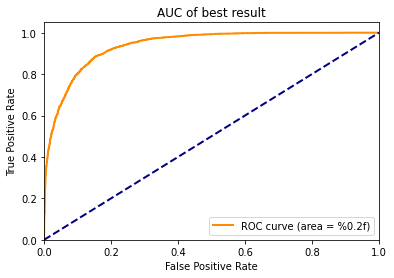

AUC in train set: 0.9388321323747063


In [ ]:
## We have initially used RandomForset for first level tuning and XGB for results improvement.

### Hyper Params: We have used manual execution to define best setup of several HyperParams  ####
### Hyper params validated on Random Forest
### 1. threshold - the percentage of missing values for dropping a feature
### 2. filling missing values strategy - 'most_frequent', 'mean', 'median'
### 3. train\test fraction

### Hyper params validated on XGBOOST



algorithm = "XGB"
    
if (algorithm == "RF"):
  clf=RandomForestClassifier(n_estimators=450)
  test(actual_train_set, actual_test_set, target_col, algorithm, clf, "test")
elif (algorithm == "XGB"):
  clf = xgb.XGBClassifier(seed=1,verbose_eval=True, n_jobs =-1, max_depth =7,learning_rate=0.3, reg_lambda =250, tree_method='gpu_hist')
  test(actual_train_set, actual_test_set, target_col, algorithm, clf, "test")






	


*Mount* google drive: